In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler
from utils.test_handler import ACDC2017TestHandler, test_ensemble
from utils.test_results import TestResults, load_all_results
from utils.referral_handler import ReferralHandler, ReferralResults
from plotting.learning_curves import loss_plot
from plotting.uncertainty_plots import analyze_slices
from plotting.main_seg_results import plot_seg_erros_uncertainties
from plotting.result_plots import plot_referral_results
from plotting.entropy_map_plots import plot_entropy_map_for_patient
from plotting.result_plots import plot_referral_results

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [9]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
LOG_DIR = os.path.join(ROOT_DIR, "logs")
# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
np.random.seed(SEED)

# IMPORTANT - THE FOLD WE'RE USING FOR TESTING. NOTE: Training and testing fold should be the same
# we raise an error in the test_ensemble method if this is not the case!
TEST_FOLD = 3

exp_mc01_brier = {3: "20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02",
                  2: "20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02",
                  1: "20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02",
                  0: "20180418_15_02_05_dcnn_mcv1_150000E_lr2e02"}

exp_mc01_brier_path = os.path.join(LOG_DIR, exp_mc01_brier[TEST_FOLD])
exper_hdl_mc01_brier = ExperimentHandler()
exper_hdl_mc01_brier.load_experiment(exp_mc01_brier_path, use_logfile=False)
exper_hdl_mc01_brier.set_root_dir(ROOT_DIR)
exper_hdl_mc01_brier.set_model_name("MC-dropout brier fold-{} (p={})".format(
                                exper_hdl_mc01_brier.exper.run_args.fold_ids[0],
                                exper_hdl_mc01_brier.exper.run_args.drop_prob))
print("Model name: {}".format(exper_hdl_mc01_brier.model_name))
print("-------------------------------------------------------------------------")

test_set_flipped = ACDC2017TestHandler(exper_config=exper_hdl_mc01_brier.exper.config, 
                               search_mask=config.dflt_image_name + ".mhd", fold_ids=[TEST_FOLD],
                               debug=False, batch_size=25, use_cuda=True, load_train=False, load_val=True,
                               use_iso_path=True, generate_flipped_images=True)

test_set = ACDC2017TestHandler(exper_config=exper_hdl_mc01_brier.exper.config, 
                               search_mask=config.dflt_image_name + ".mhd", fold_ids=[TEST_FOLD],
                               debug=False, batch_size=25, use_cuda=True, load_train=False, load_val=True,
                               use_iso_path=True, generate_flipped_images=False)

  4%|▍         | 1/25 [00:00<00:02,  8.75it/s]

Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/exper_stats.dll
Model name: dcnn_mc p=0.10 fold=3 loss=brier
-------------------------------------------------------------------------
INFO - Testhandler - >>> Search in val-dir for /home/jorg/repository/dcnn_acdc/data/Folds/fold3/validate/images_iso/*patient*.mhd <<<
INFO - File list contains 50 files, hence 25 patients


100%|██████████| 25/25 [00:01<00:00, 13.02it/s]


INFO - Successfully loaded 25 ED/ES patient pairs
INFO - Generated >>flipped<< images in objects images_flipped/labels_flipped.


In [67]:
checkpoints = [100000, 110000, 120000, 130000, 140000, 150000]
mc_samples = 10
patient_ids = ["patient0082"]  #, "patient082"]

exper_hdl_mc01_brier.create_u_maps(model=None, checkpoints=checkpoints, mc_samples=mc_samples,
                                        u_threshold=0., verbose=False, save_actual_maps=True, test_set=test_set,
                                        generate_figures=False, aggregate_func="max",
                                        store_test_results=False, patient_ids=patient_ids)
exper_handler.create_filtered_umaps(u_threshold=0.08, patient_id=patient_ids[0])

  0%|          | 0/1 [00:00<?, ?it/s]

INFO - Starting to generate uncertainty maps (agg-func=max) for 25 images using 10 samples and u-threshold 0.00
INFO - Using patient ids patient0082
Predictions for patient0082 with #samples=10 without referral (use-mc=True)
Loading existing model with checkpoint /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/checkpoints from dir 100000
Loading existing model with checkpoint /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/checkpoints from dir 110000
Loading existing model with checkpoint /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/checkpoints from dir 120000
Loading existing model with checkpoint /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/checkpoints from dir 130000
Loading existing model with checkpoint /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/checkpoints from dir 140000


100%|██████████| 1/1 [02:11<00:00, 131.77s/it]


INFO - Successfully saved 1 maps to /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/u_maps
INFO - Total duration of generation process 131.78 secs


In [50]:
exper_handler.create_filtered_umaps(u_threshold=0.08, patient_id="patient0045")

In [65]:
from utils.referral_handler import ReferralHandler

referral_thresholds = [0.08]
type_of_map = "entropy"

exper_handler.get_patients(use_four_digits=True)

ref_handler = ReferralHandler(exper_handler, test_set=test_set,
                                          referral_thresholds=referral_thresholds,
                                          aggregate_func="max",
                                          verbose=True, do_save=False, num_of_images=None,
                                          type_of_map=type_of_map,
                                          patients=patient_ids)  # ["patient082", "patient084"])
# referral_only -> we don't create the filtered maps (u-map or entropy)
ref_handler.test(referral_only=True, slice_filter_type=None, verbose=False)

INFO - Running for ['patient0082'] only
INFO - Saved all entropy maps to /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/u_maps
INFO - Running evaluation with referral for threshold 0_08 (referral-only=True/do-filter-slices=False/filter_type=None/type-of-map=entropy/use_entropy_maps=True/use_raw_maps=False)
patient0082: Ref% ES/ED 0.00/0.00 - #Errors before/after reduction ES: 6052.0/985.0 ED: 6074.0/755.0
Overall result wo referral -  dice(RV/Myo/LV):	ES 0.87/0.91/0.93	ED 0.93/0.89/0.97
Overall result referral -  dice(RV/Myo/LV):	ES 0.97/0.99/0.99	ED 0.99/0.99/1.00
------------------------------ Results for class NOR ----------------------------------
ES & ED Mean/median u-value 0.00/0.00 & 0.00/0.00	 % slices referred 0.00 & 0.00
without referral - dice(RV/Myo/LV):	ES 0.00/0.00/0.00	ED 0.00/0.00/0.00
   with referral - dice(RV/Myo/LV):	ES 0.00/0.00/0.00	ED 0.00/0.00/0.00
without referral - HD (RV/Myo/LV):	ES 0.00/0.00/0.00	ED 0.00/0.00/0.00
   

In [ ]:
import copy
from common.common import overlay_seg_mask, to_rgb1a

patient_id = "patient0082"
test_img_idx = test_set.trans_dict[patient_id]
print("test_img_idx ", test_img_idx)

def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"

    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap


#Use base cmap to create transparent
mycmap = transparent_cmap(plt.get_cmap('jet'))

exper_handler = exper_hdl_mc01_brier
input_dir = os.path.join(exper_handler.exper.config.root_dir,
                                           os.path.join(exper_handler.exper.output_dir, 
                                                        config.u_map_dir))
pred_lbl_input_dir = os.path.join(exper_handler.exper.config.root_dir,
                                           os.path.join(exper_handler.exper.output_dir, 
                                                        config.pred_lbl_dir))

file_name_umap = os.path.join(input_dir, patient_id + "_raw_umaps.npz")

file_name_lbl = os.path.join(pred_lbl_input_dir, patient_id + "_pred_labels_mc.npz")

file_name_ref_lbl = os.path.join(pred_lbl_input_dir, patient_id + "_pred_labels_mc.npz")

umap_data = np.load(file_name_umap)
# shape [2, 4cls, w, h, #slices]
umap = umap_data["u_map"]
data_lbl = np.load(file_name_lbl)
# shape [8cls, w, h, #slices]
pred_labels = data_lbl["pred_labels"]
print(umap.shape, pred_labels.shape)
data_ref_lbl = np.load(file_name_ref_lbl)

phase = 0
cls_offset = phase * 4
slice_id = 14

org_img = test_set.images[test_img_idx]
org_img = org_img[:, config.pad_size:-config.pad_size, config.pad_size:-config.pad_size, :]
org_ref = test_set.labels[test_img_idx]
org_img_ed = org_img[phase]
org_img_ed_slice = org_img_ed[:, :, slice_id]
print("org_img_ed_slice ", org_img_ed_slice.shape)
if phase == 0:
    umap_slice = np.max(umap[phase, :4, :, :, slice_id], axis=0)
else:
    umap_slice = np.max(umap[phase, 4:, :, :, slice_id], axis=0)
print(umap_slice.shape)

rgb_org_img_ed_slice = to_rgb1a(org_img_ed_slice)
saved_rgb_copy = copy.deepcopy(rgb_org_img_ed_slice)
org_ref_ed_slice = org_ref[:, :, :, slice_id]
pred_ref_ed_slice = pred_labels[:, :, :, slice_id]

img_slice_with_gt_segs = overlay_seg_mask(rgb_org_img_ed_slice, org_ref_ed_slice, cls_offset=0)
rgb_org_img_ed_slice = copy.deepcopy(saved_rgb_copy)
mg_slice_with_pred_segs = overlay_seg_mask(rgb_org_img_ed_slice, pred_ref_ed_slice, cls_offset=0)

fig = plt.figure(figsize=(15, 25))
ax4plot = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
ax4plot.imshow(org_img_ed_slice, cmap=plt.get_cmap('gray'))
plt.axis("off")
ax4aplot = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=2)
ax4aplot.set_title("with GT")
ax4aplot = plt.imshow(img_slice_with_gt_segs)

plt.axis("off")
ax4bplot = plt.subplot2grid((4, 4), (2, 0), rowspan=2, colspan=2)
ax4bplot.set_title("with pred segs")
ax4bplot = plt.imshow(mg_slice_with_pred_segs)
plt.axis("off")
ax4bplot = plt.subplot2grid((4, 4), (2, 2), rowspan=2, colspan=2)
ax4bplot = plt.imshow(org_img_ed_slice, cmap=cm.gray)
ax4bplot = plt.imshow(umap_slice, cmap=mycmap)

plt.axis("off")

In [ ]:
model_name = exper_handler.exper.model_name
plot_seg_erros_uncertainties(exper_handler, test_set, patient_id="patient0045", 
                             test_results=None, # exper_handler.test_results
                             referral_threshold=0.08, do_show=True, slice_filter_type=None,
                             model_name=model_name, info_type="uncertainty", 
                             do_save=True, slice_range=None, errors_only=False,
                             load_base_model_pred_labels=False, umaps_without_postprocessing=False)

INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/figures/patient0082/patient0082_entropy_map_0_08.pdf


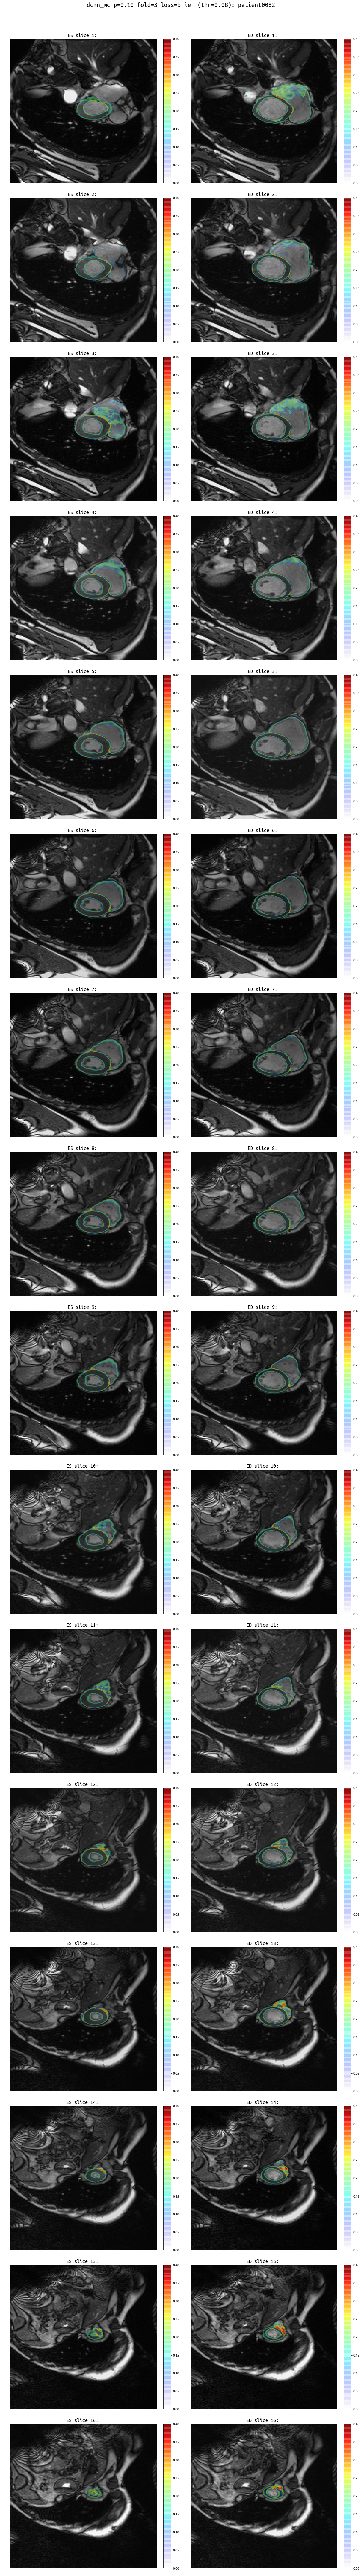

In [66]:
patient_id = "patient0082"
# "patient100"
exper_handler.test_set = test_set

plot_entropy_map_for_patient(exper_handler, patient_id, do_save=True, threshold=0.08)

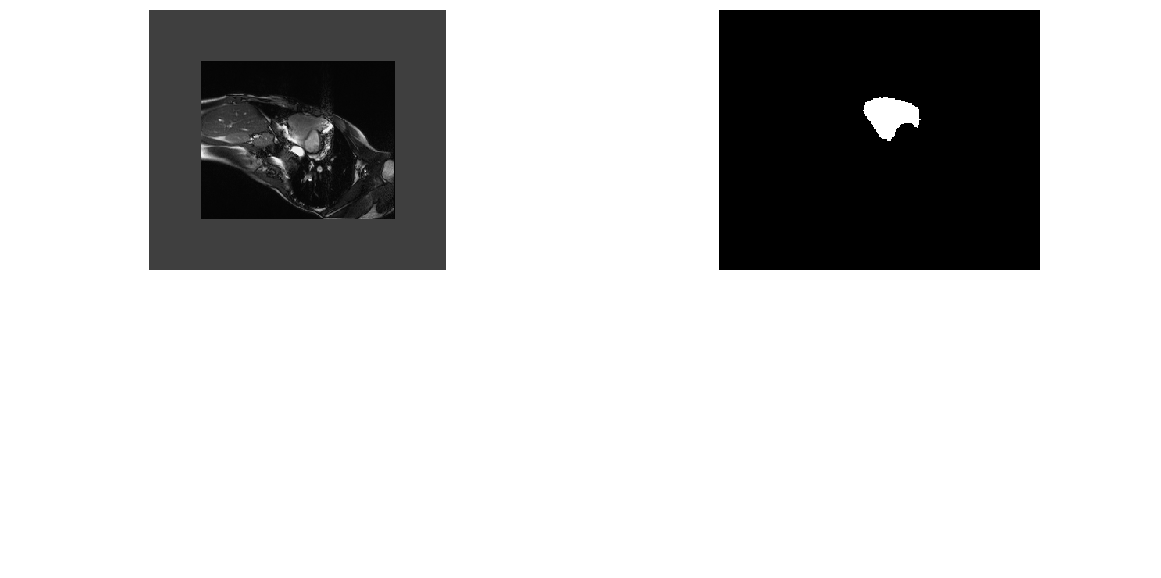

In [7]:
patient_id = "patient0082"

idx = test_set.trans_dict[patient_id]

image, label = test_set.images[idx], test_set.labels[idx]
# image_flipped, label_flipped = test_set.images_flipped[idx], test_set.labels_flipped[idx]
#image = image[:, config.pad_size:-config.pad_size, config.pad_size:-config.pad_size, :]
#label = label[:, config.pad_size:-config.pad_size, config.pad_size:-config.pad_size, :]
#image_flipped = image_flipped[:, config.pad_size:-config.pad_size, config.pad_size:-config.pad_size, :]
#label_flipped = label_flipped[:, config.pad_size:-config.pad_size, config.pad_size:-config.pad_size, :]

rows = image.shape[3]
rows = 4
columns = 4
width = 20
height = 10
phase = 0
cls_offset = phase * 4
RV_class = 1 + cls_offset

fig = plt.figure(figsize=(width, height))
ax1 = plt.subplot2grid((rows , columns), (0, 0), rowspan=2, colspan=2)
ax2 = plt.subplot2grid((rows , columns), (0, 2), rowspan=2, colspan=2)
ax3 = plt.subplot2grid((rows , columns), (2, 0), rowspan=2, colspan=2)
ax4 = plt.subplot2grid((rows , columns), (2, 2), rowspan=2, colspan=2)
for slice_id in [0]:
    img_slice = image[phase, :, :, slice_id]
    # img_flipped_slice = image_flipped[phase, :, :, slice_id]
    lbl_slice = label[RV_class, :, :, slice_id]
    # lbl_flipped_slice = label_flipped[RV_class, :, :, slice_id]
    ax1.imshow(img_slice, cmap="gray")
    ax2.imshow(lbl_slice, cmap="gray")
    # ax3.imshow(lbl_slice, cmap="gray")
    # ax4.imshow(lbl_flipped_slice, cmap="gray")
ax1.axis("off")
ax2.axis("off")
ax3.axis("off")
ax4.axis("off")
plt.show()